In [1]:
import pandas as pd
import re,string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost.sklearn import XGBClassifier

In [2]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [3]:
from nltk.corpus import wordnet

In [4]:
data = pd.read_csv('/kaggle/input/fake-reviews/fake reviews dataset.csv')

In [5]:
data.drop('category', inplace=True, axis=1)

In [6]:
data.label=data.label.apply(lambda x: 0 if x=='CG' else 1)

data.head()

,rating,label,text_
0,5.0,0,"Love this! Well made, sturdy, and very comfor..."
1,5.0,0,"love it, a great upgrade from the original. I..."
2,5.0,0,This pillow saved my back. I love the look and...
3,1.0,0,"Missing information on how to use it, but it i..."
4,5.0,0,Very nice set. Good quality. We have had the s...


In [7]:
eng_stopwords = set(stopwords.words("english"))

data['count_sent']=data["text_"].apply(lambda x: len(re.findall("\n",str(x)))+1)

data['count_word']=data["text_"].apply(lambda x: len(str(x).split()))

data['count_unique_word']=data["text_"].apply(lambda x: len(set(str(x).split())))

data['count_letters']=data["text_"].apply(lambda x: len(str(x)))

data["count_punctuations"] =data["text_"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

data["count_words_upper"] = data["text_"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

data["count_words_title"] = data["text_"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

data["count_stopwords"] = data["text_"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

data["mean_word_len"] = data["text_"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

data['word_unique_percent']=data['count_unique_word']*100/data['count_word']

data['punct_percent']=data['count_punctuations']*100/data['count_word']

data['word_unique_percent']=data['count_unique_word']*100/data['count_word']

data['punct_percent']=data['count_punctuations']*100/data['count_word']

data = data[['text_', 'count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent','label']]

data.head()

,text_,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,label
0,"Love this! Well made, sturdy, and very comfor...",1,12,12,75,5,1,3,3,5.166667,100.000000,41.666667,0
1,"love it, a great upgrade from the original. I...",1,16,15,80,3,0,0,7,4.000000,93.750000,18.750000,0
2,This pillow saved my back. I love the look and...,1,14,14,67,2,1,2,7,3.857143,100.000000,14.285714,0
3,"Missing information on how to use it, but it i...",1,17,17,81,2,1,2,10,3.764706,100.000000,11.764706,0
4,Very nice set. Good quality. We have had the s...,1,18,17,85,2,0,3,11,3.777778,94.444444,11.111111,0


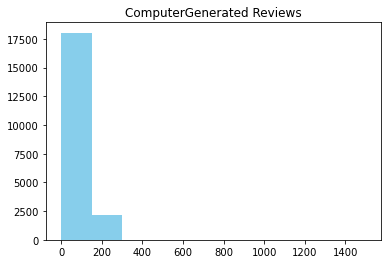

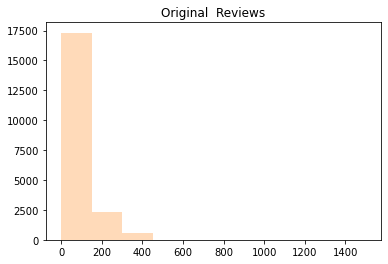

In [8]:
plt.hist(data[data['label']==0]['count_word'],range=(0,1500),color='SkyBlue')
plt.title('ComputerGenerated Reviews')
plt.show()

plt.hist(data[data['label']==1]['count_word'],range=(0,1500),color='PeachPuff')
plt.title('Original  Reviews')
plt.show()

In [9]:
data.groupby(['label'],as_index=False).mean()

,label,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0,1.626237,61.288237,38.424763,305.573506,8.625594,3.138702,6.591710,33.769490,4.046509,76.927998,15.341096
1,1,1.946280,73.642610,54.416799,396.970419,11.811436,2.683914,7.717649,35.220024,4.358762,84.008864,16.276065


In [10]:
# Removing all punctuations from review
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "don't" : "do not"}

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text_):
    return text_.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_contractions(text_, mapping):
    specials = ["’", "‘", "´", "`", "_"]
    for s in specials:
        if s == "_":
          text_ = text_.replace(s, " ")
        else:
          text_ = text_.replace(s, "'")
    text_ = ' '.join([mapping[t] if t in mapping else t for t in text_.split(" ")])
    return text_


from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text_):
    return " ".join([word for word in str(text_).split() if word not in STOPWORDS])

def word_replace(text_):
    return text_.replace('<br />','')


from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text_):
    return " ".join([stemmer.stem(word) for word in text_.split()])


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text_):
    return " ".join([lemmatizer.lemmatize(word) for word in text_.split()])


def remove_urls(text_):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text_)


def remove_html(text_):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text_)


def preprocess(text_):
    text_=clean_contractions(text_,mapping)
    text_=text_.lower()
    text_=word_replace(text_)
    text_=remove_urls(text_)
    text_=remove_html(text_)
    text_=remove_stopwords(text_)
    text_=remove_punctuation(text_)
    # review=stem_words(review)
    text_=lemmatize_words(text_)
    
    return text_

In [11]:
data["text_p"] = data["text_"].apply(lambda text_: preprocess(text_))

In [12]:
print(data[['text_', 'text_p']])

                                                   text_  \
0      Love this!  Well made, sturdy, and very comfor...   
1      love it, a great upgrade from the original.  I...   
2      This pillow saved my back. I love the look and...   
3      Missing information on how to use it, but it i...   
4      Very nice set. Good quality. We have had the s...   
...                                                  ...   
40427  I had read some reviews saying that this bra r...   
40428  I wasn't sure exactly what it would be. It is ...   
40429  You can wear the hood by itself, wear it with ...   
40430  I liked nothing about this dress. The only rea...   
40431  I work in the wedding industry and have to wor...   

                                                  text_p  
0      love this well made sturdy comfortable love it...  
1        love it great upgrade original mine couple year  
2                pillow saved back love look feel pillow  
3         missing information use it great 

In [13]:
text_s = data['text_p']

In [14]:
text_s

0        love this well made sturdy comfortable love it...
1          love it great upgrade original mine couple year
2                  pillow saved back love look feel pillow
3           missing information use it great product price
4                      nice set good quality set two month
                               ...                        
40427    read review saying bra ran small ordered two b...
40428    sure exactly would be little large small size ...
40429    wear hood itself wear hood wear jacket without...
40430    liked nothing dress reason gave 4 star ordered...
40431    work wedding industry work long day foot outsi...
Name: text_p, Length: 40432, dtype: object

In [15]:
array = np.load('/kaggle/input/label-encoded-value/my_array.npy', allow_pickle=True)


In [16]:
# Create a pandas Series with the text

# Split the text into words
#word_lists = text_s.str.split().apply(lambda x: [word for word in x])

#print(word_lists)

In [17]:
#from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
#le = LabelEncoder()

# Fit the LabelEncoder on all the words
#all_words = [word for word_list in word_lists for word in word_list]
#le.fit(all_words)

# Transform each list of words into a list of labels
#labelled_lists = [le.transform(word_list) for word_list in word_lists]

In [18]:
#labelled_lists

In [19]:
#lists = [array.tolist() for array in labelled_lists]
#lists

In [20]:
#len(lists)

In [21]:
#array = np.array(lists)
#print(array)

In [22]:
def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)
    

In [23]:
X=data[['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']]
#X = data[['text_p','rating']]
y=data['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


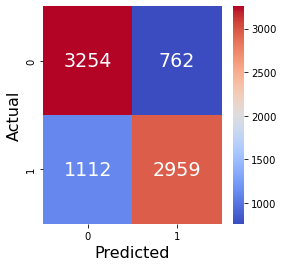


Accuracy:  0.77

F1 Score:  0.76

Report:               precision    recall  f1-score   support

           0       0.75      0.81      0.78      4016
           1       0.80      0.73      0.76      4071

    accuracy                           0.77      8087
   macro avg       0.77      0.77      0.77      8087
weighted avg       0.77      0.77      0.77      8087



In [25]:
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(X_train, y_train)
metrics(classifier,X_test,y_test)

In [26]:
reviews = ' '.join(data['text_p'])
string = reviews.split(" ")

In [27]:
string

['love',
 'this',
 'well',
 'made',
 'sturdy',
 'comfortable',
 'love',
 'itvery',
 'pretty',
 'love',
 'it',
 'great',
 'upgrade',
 'original',
 'mine',
 'couple',
 'year',
 'pillow',
 'saved',
 'back',
 'love',
 'look',
 'feel',
 'pillow',
 'missing',
 'information',
 'use',
 'it',
 'great',
 'product',
 'price',
 'nice',
 'set',
 'good',
 'quality',
 'set',
 'two',
 'month',
 'wanted',
 'different',
 'flavor',
 'not',
 'perfect',
 'touch',
 'thing',
 'wish',
 'little',
 'space',
 'done',
 'fit',
 'well',
 'look',
 'great',
 'love',
 'smoothness',
 'edge',
 'extra',
 'great',
 'big',
 'number',
 'easy',
 'read',
 'thing',
 'like',
 'size',
 'son',
 'love',
 'comforter',
 'well',
 'made',
 'also',
 'baby',
 'advertised',
 '5th',
 'one',
 'had',
 'problem',
 'really',
 'handy',
 'one',
 'kid',
 'tool',
 'included',
 'package',
 'one',
 'someone',
 'say',
 'oriental',
 '60',
 'great',
 'product',
 'flimsy',
 'quality',
 'would',
 'expect',
 'piece',
 'furniture',
 'make',
 'may',
 'tea'

In [28]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:7]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (10,5))
    return sns.barplot(x='count',y='word', data=n_gram_df)

       word  count
0   (book,)  17289
1  (great,)  16428
2   (love,)  15430
3    (one,)  14553
4   (good,)  14223


<AxesSubplot:xlabel='count', ylabel='word'>

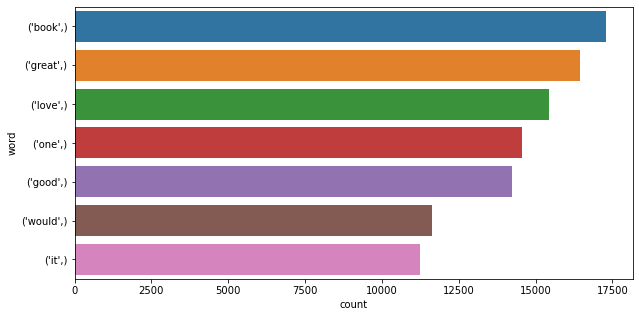

In [29]:
draw_n_gram(string,1)

                  word  count
0   (would, recommend)   2997
1           (love, it)   2303
2  (highly, recommend)   1433
3         (read, book)   1421
4      (well, written)   1322


<AxesSubplot:xlabel='count', ylabel='word'>

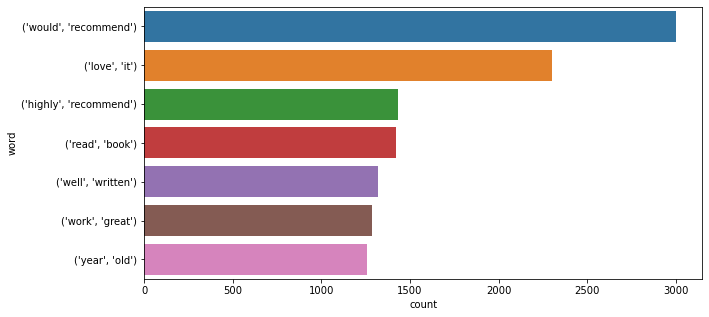

In [30]:
draw_n_gram(string,2)

                             word  count
0    (character, well, developed)    933
1      (would, recommend, anyone)    796
2  (would, definitely, recommend)    600
3      (exchange, honest, review)    534
4             (story, well, told)    441


<AxesSubplot:xlabel='count', ylabel='word'>

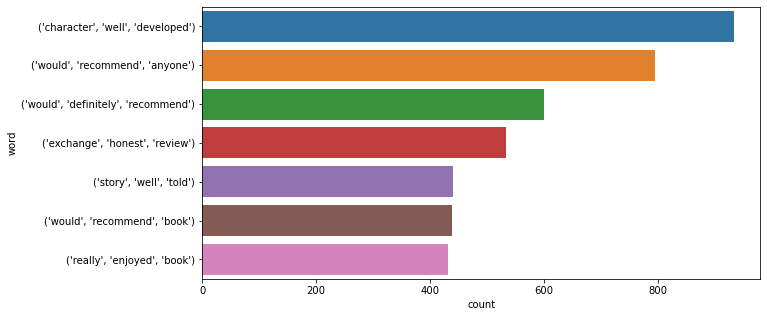

In [31]:
draw_n_gram(string,3)

In [32]:
data['text_p']

0        love this well made sturdy comfortable love it...
1          love it great upgrade original mine couple year
2                  pillow saved back love look feel pillow
3           missing information use it great product price
4                      nice set good quality set two month
                               ...                        
40427    read review saying bra ran small ordered two b...
40428    sure exactly would be little large small size ...
40429    wear hood itself wear hood wear jacket without...
40430    liked nothing dress reason gave 4 star ordered...
40431    work wedding industry work long day foot outsi...
Name: text_p, Length: 40432, dtype: object

In [33]:
data['label']

0        0
1        0
2        0
3        0
4        0
        ..
40427    1
40428    0
40429    1
40430    0
40431    1
Name: label, Length: 40432, dtype: int64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data['text_p'], data['label'], test_size=0.2,random_state=42)

In [35]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(32345,), (8087,), (32345,), (8087,)]

In [36]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=10000
)

word_vectorizer.fit(data['text_p'])

tfidf_train = word_vectorizer.transform(X_train)
tfidf_test = word_vectorizer.transform(X_test)

In [37]:
print('Shape of tfidf_train:',tfidf_train.shape)
print('Shape of tfidf_test:',tfidf_test.shape)

Shape of tfidf_train: (32345, 10000)
Shape of tfidf_test: (8087, 10000)


In [38]:
cv=CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}',ngram_range=(1,3),max_features=10000)
cv.fit(data['text_p'])
cv_train=cv.transform(X_train)
cv_test=cv.transform(X_test)

In [39]:
print('Shape of cv_train:',cv_train.shape)
print('Shape of cv_test:',cv_test.shape)

Shape of cv_train: (32345, 10000)
Shape of cv_test: (8087, 10000)


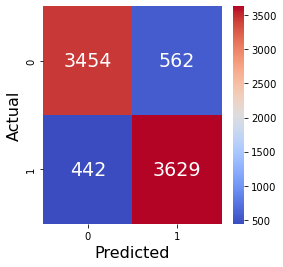


Accuracy:  0.88

F1 Score:  0.88

Report:               precision    recall  f1-score   support

           0       0.89      0.86      0.87      4016
           1       0.87      0.89      0.88      4071

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



In [40]:
# Logistic Regression with TF-IDF
classifier = LogisticRegression(penalty='l2',C=0.5, solver = 'newton-cg')
classifier.fit(tfidf_train, y_train)
metrics(classifier,tfidf_test,y_test)

In [41]:
from sklearn.naive_bayes import MultinomialNB

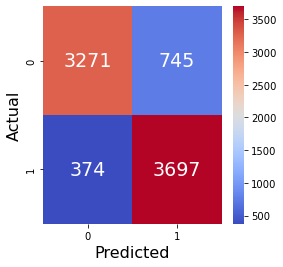


Accuracy:  0.86

F1 Score:  0.87

Report:               precision    recall  f1-score   support

           0       0.90      0.81      0.85      4016
           1       0.83      0.91      0.87      4071

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087



In [42]:
#Naive Bayes with TF-IDF
model= MultinomialNB()

model.fit(tfidf_train, y_train)
metrics(model,tfidf_test,y_test)

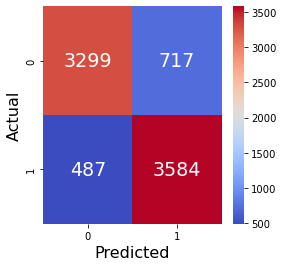


Accuracy:  0.85

F1 Score:  0.86

Report:               precision    recall  f1-score   support

           0       0.87      0.82      0.85      4016
           1       0.83      0.88      0.86      4071

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087



In [43]:
#Naive Bayes with Count Vectorizer
modela= MultinomialNB()

modela.fit(cv_train, y_train)
metrics(modela,cv_test,y_test)

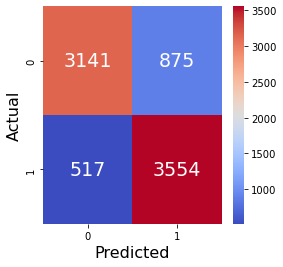


Accuracy:  0.83

F1 Score:  0.84

Report:               precision    recall  f1-score   support

           0       0.86      0.78      0.82      4016
           1       0.80      0.87      0.84      4071

    accuracy                           0.83      8087
   macro avg       0.83      0.83      0.83      8087
weighted avg       0.83      0.83      0.83      8087



In [44]:
#Default XGBoost Model with TF_IDF
model = XGBClassifier() 
model.fit(tfidf_train, y_train)

metrics(model,tfidf_test,y_test)

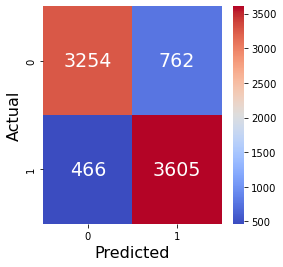


Accuracy:  0.85

F1 Score:  0.85

Report:               precision    recall  f1-score   support

           0       0.87      0.81      0.84      4016
           1       0.83      0.89      0.85      4071

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087



In [45]:
#Default XGBoost Model with Count Vectorizer
modelcv = XGBClassifier() 
modelcv.fit(cv_train, y_train)

metrics(modelcv,cv_test,y_test)


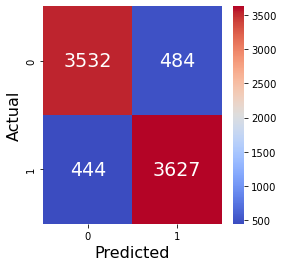


Accuracy:  0.89

F1 Score:  0.89

Report:               precision    recall  f1-score   support

           0       0.89      0.88      0.88      4016
           1       0.88      0.89      0.89      4071

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



In [46]:
#SVM with TF-IDF
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(penalty='l2')
linear_svc.fit(tfidf_train, y_train)
metrics(linear_svc,tfidf_test,y_test)

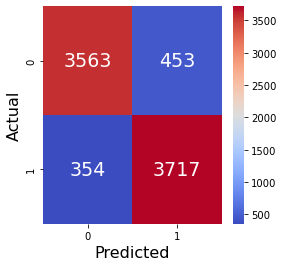


Accuracy:  0.9

F1 Score:  0.9

Report:               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4016
           1       0.89      0.91      0.90      4071

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087



In [47]:
#SVM with Count Vectorizer
linear_svc1 = LinearSVC(C=0.1, random_state=20000)
linear_svc1.fit(cv_train, y_train)

metrics(linear_svc1,cv_test,y_test)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

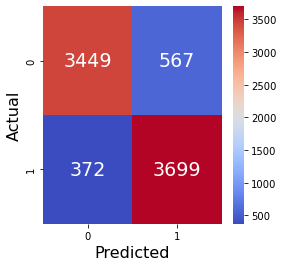


Accuracy:  0.88

F1 Score:  0.89

Report:               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4016
           1       0.87      0.91      0.89      4071

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



In [49]:
#Default SGD Model with TF_IDF
model = SGDClassifier() 
model.fit(tfidf_train, y_train)

metrics(model,tfidf_test,y_test)

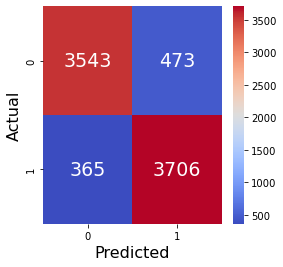


Accuracy:  0.9

F1 Score:  0.9

Report:               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4016
           1       0.89      0.91      0.90      4071

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087



In [50]:
#Default SGD Model with Count Vectorizer
modelcv = SGDClassifier() 
modelcv.fit(cv_train, y_train)

metrics(modelcv,cv_test,y_test)


In [51]:
X=data['text_p']
y=data['label']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [53]:
X_train.shape

(32345,)

In [54]:
y_train.shape

(32345,)

In [55]:
y_test.shape

(8087,)

In [56]:
y_train.shape

(32345,)

In [57]:
review_len=[len(review) for review in data['text_p']]

In [58]:
# Since vocabulary size is restricted to VOCAB_SIZE, no word index should be greater than VOCAB_SIZE
VOCAB_SIZE=25000

max_index = max ( [max(review_len) for review in array] )

print("VOCAB_SIZE          =", VOCAB_SIZE)
print("Max index of a word =", max_index)

VOCAB_SIZE          = 25000
Max index of a word = 1592


In [59]:
X1=array
y1=data['label']

In [60]:
y1

0        0
1        0
2        0
3        0
4        0
        ..
40427    1
40428    0
40429    1
40430    0
40431    1
Name: label, Length: 40432, dtype: int64

In [61]:
y2=np.array(y)

In [62]:
y2

array([0, 0, 0, ..., 1, 0, 1])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X1,y2, test_size=0.2,random_state=42)

In [64]:
max_train_length = max (len(review) for review in X_train )
max_test_length = max (len(review) for review in X_test)

In [65]:
max_length = max(max_train_length, max_test_length)
print("Maximum length of a review in dataset:", max_length)

Maximum length of a review in dataset: 240


In [66]:
from keras_preprocessing.sequence import pad_sequences

# Pad each review in the dataset till their length = max_length
print("Padding the reviews...")
X_train = pad_sequences (X_train, maxlen=max_length)
X_test = pad_sequences (X_test, maxlen=max_length)

print("Shape of train_data =", X_train.shape)
print("Shape of test_data  =", X_test.shape)

Padding the reviews...
Shape of train_data = (32345, 240)
Shape of test_data  = (8087, 240)


In [67]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, GlobalAveragePooling1D
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim = 50000,
                    output_dim = 128,
                    input_length = max_length))
model.add(Conv1D(filters = 128,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu',
                ))
model.add(MaxPooling1D(pool_size = 7))
model.add(GlobalMaxPooling1D())
model.add(Dense(units = 32,
                activation = 'relu'))
model.add(Dense(units = 1,
                activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 240, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 238, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 34, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,453,441
Trainable params: 6,453,441
Non-trainable params: 0
______________________________________________

In [68]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [69]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_CNNmodel.hdf5',
                     monitor = 'val_acc',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_acc',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]

In [70]:
history = model.fit(X_train,y_train,epochs = 100,batch_size = 32,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/100
991/991 [==============================] - 18s 8ms/step - loss: 0.3340 - acc: 0.8514 - val_loss: 0.2465 - val_acc: 0.9011

Epoch 00001: val_acc improved from -inf to 0.90108, saving model to ./best_CNNmodel.hdf5
Epoch 2/100
991/991 [==============================] - 8s 8ms/step - loss: 0.1266 - acc: 0.9519 - val_loss: 0.2333 - val_acc: 0.9057

Epoch 00002: val_acc improved from 0.90108 to 0.90572, saving model to ./best_CNNmodel.hdf5
Epoch 3/100
991/991 [==============================] - 8s 8ms/step - loss: 0.0376 - acc: 0.9875 - val_loss: 0.2884 - val_acc: 0.8995

Epoch 00003: val_acc did not improve from 0.90572
Epoch 4/100
991/991 [==============================] - 9s 9ms/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.3351 - val_acc: 0.8995

Epoch 00004: val_acc did not improve from 0.90572
Epoch 5/100
991/991 [==============================] - 8s 8ms/step - loss: 0.0061 - acc: 0.9984 - val_loss: 0.4241 - val_acc: 0.9042

Epoch 00005: val_acc did not improve from 0.9057

In [71]:
print("Best Validation Accuracy =", max(history.history['val_acc'])*100)
print("Best Training Accuracy =", max(history.history['acc'])*100)

Best Validation Accuracy = 90.88099002838135
Best Training Accuracy = 100.0


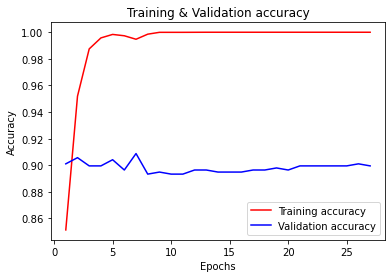

In [72]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

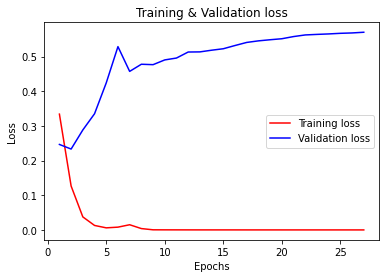

In [73]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [74]:
test_metrics = model.evaluate(X_test, y_test)

253/253 [==============================] - 1s 3ms/step - loss: 0.5546 - acc: 0.8902


In [75]:
test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

Test Accuracy : 0.8901941180229187
Test Accuracy : 0.5546355247497559


In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[3551  465]
 [ 423 3648]]


              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4016
           1       0.89      0.90      0.89      4071

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087

Precision: 0.886943836615609
Recall: 0.8960943257184967
Accuracy: 0.8901941387411896


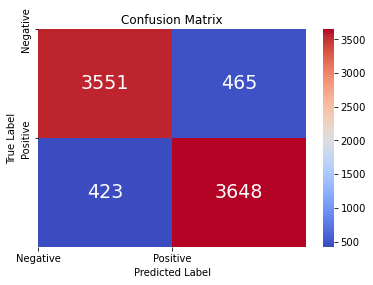

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate classification report and confusion matrix
class_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and accuracy values from the confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Print classification report and precision/recall/accuracy values
print(class_report)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Plot confusion matrix
#plt.imshow(cm, cmap=plt.cm.Blues)
sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.title("Confusion Matrix")
#plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], labels=["Negative", "Positive"])
plt.yticks([0, 1], labels=["Negative", "Positive"])
plt.show()


In [78]:
pred_prob1 = model.predict(X_test)

In [79]:
pred_prob1

array([[2.0730724e-09],
       [7.2981329e-13],
       [9.9999690e-01],
       ...,
       [2.5707518e-08],
       [9.9999988e-01],
       [9.9991119e-01]], dtype=float32)

In [80]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


In [81]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1)


print(auc_score1)

0.9584609853389195


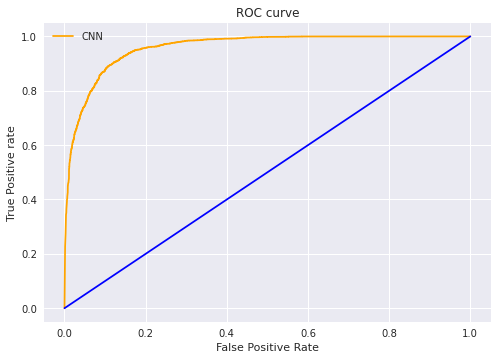

In [82]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1,color='orange', label='CNN')
plt.plot(p_fpr, p_tpr, color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**LSTM**

In [83]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=50000, 
                    output_dim=32,
                    input_length=max_length))
model.add(LSTM(units=128, 
               activation = 'tanh', 
               recurrent_activation = 'sigmoid', 
               dropout = 0.0, 
               recurrent_dropout = 0.0, 
               return_sequences = False,
            #    kernel_regularizer = l2(0.01),
            #    recurrent_regularizer = l2(0.01),
            #    bias_regularizer = l2(0.01)
            ))
model.add(Dense(units = 64,
                activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 32,
                activation = 'relu'))
model.add(Dense(units = 1, 
                activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 240, 32)           1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,692,801
Trainable params: 1,692,801
Non-trainable params: 0
____________________________________________

In [84]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [85]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_LSTMmodel_2.hdf5',
                     monitor = 'val_acc',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),
                 
                 EarlyStopping(
                    monitor = 'val_acc',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0,
                 ),

                 TerminateOnNaN()
]

In [86]:
history = model.fit(X_train,
                    y_train,
                    batch_size = 64,
                    epochs = 100,
                    verbose = 1,
                    callbacks = callback_list,
                    validation_split = 0.00512,
                    shuffle = True)

Epoch 1/100
503/503 [==============================] - 11s 17ms/step - loss: 0.3610 - acc: 0.8324 - val_loss: 0.2330 - val_acc: 0.8916

Epoch 00001: val_acc improved from -inf to 0.89157, saving model to ./best_LSTMmodel_2.hdf5
Epoch 2/100
503/503 [==============================] - 9s 18ms/step - loss: 0.1913 - acc: 0.9221 - val_loss: 0.1436 - val_acc: 0.9458

Epoch 00002: val_acc improved from 0.89157 to 0.94578, saving model to ./best_LSTMmodel_2.hdf5
Epoch 3/100
503/503 [==============================] - 9s 17ms/step - loss: 0.1376 - acc: 0.9460 - val_loss: 0.1575 - val_acc: 0.9277

Epoch 00003: val_acc did not improve from 0.94578
Epoch 4/100
503/503 [==============================] - 8s 17ms/step - loss: 0.1008 - acc: 0.9611 - val_loss: 0.1765 - val_acc: 0.9096

Epoch 00004: val_acc did not improve from 0.94578
Epoch 5/100
503/503 [==============================] - 8s 17ms/step - loss: 0.0697 - acc: 0.9746 - val_loss: 0.1703 - val_acc: 0.9458

Epoch 00005: val_acc did not improve 

In [87]:
print("Best Validation Accuracy =", max(history.history['val_acc'])*100)
print("Best Training Accuracy   =", max(history.history['acc'])*100)

Best Validation Accuracy = 94.57831382751465
Best Training Accuracy   = 99.91298913955688


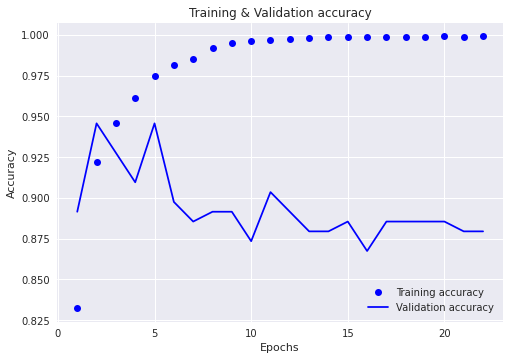

In [88]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

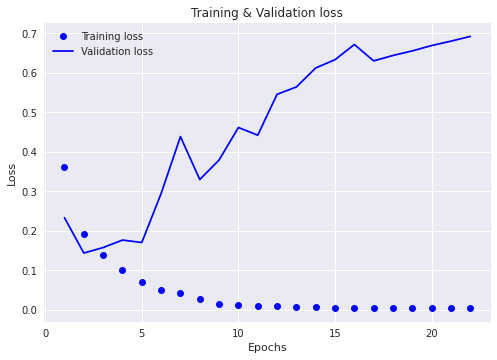

In [89]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [90]:
test_metrics = model.evaluate(X_test, y_test)

253/253 [==============================] - 2s 7ms/step - loss: 0.2290 - acc: 0.9090


In [91]:
test_accuracy = test_metrics[1] 
test_loss = test_metrics[0]
print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

Test Accuracy : 0.9089897274971008
Test Accuracy : 0.22900784015655518


In [92]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[3617  399]
 [ 337 3734]]


              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4016
           1       0.90      0.92      0.91      4071

    accuracy                           0.91      8087
   macro avg       0.91      0.91      0.91      8087
weighted avg       0.91      0.91      0.91      8087

Precision: 0.9034599564481006
Recall: 0.9172193564234832
Accuracy: 0.9089897366143193


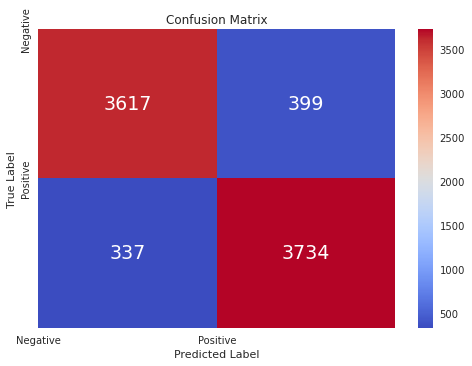

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate classification report and confusion matrix
class_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and accuracy values from the confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Print classification report and precision/recall/accuracy values
print(class_report)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Plot confusion matrix
#plt.imshow(cm, cmap=plt.cm.Blues)
sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.title("Confusion Matrix")
#plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], labels=["Negative", "Positive"])
plt.yticks([0, 1], labels=["Negative", "Positive"])
plt.show()

In [94]:
pred_prob2 = model.predict(X_test)

In [95]:
pred_prob2

array([[1.2031935e-05],
       [2.4839630e-04],
       [9.9781692e-01],
       ...,
       [5.4361854e-02],
       [9.8730403e-01],
       [9.9639112e-01]], dtype=float32)

In [96]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob2, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [97]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score2 = roc_auc_score(y_test, pred_prob2)


print(auc_score2)

0.9692915882527371


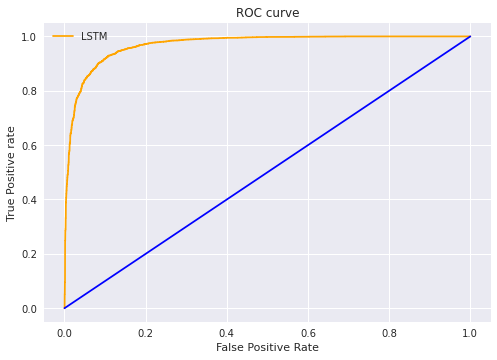

In [98]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1,color='orange', label='LSTM')
plt.plot(p_fpr, p_tpr, color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**CNN_LSTM**

In [99]:
##from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, TimeDistributed
#from keras.layers import LSTM

# Define the model
#model = Sequential()

# Add a convolutional layer
#model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3),
#                 activation='relu'), input_shape=(None, 100, 100, 3)))
#model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model.add(TimeDistributed(Flatten()))

# Add an LSTM layer
#model.add(LSTM(64))

# Add a fully connected layer
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
##model.summary()

In [100]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Embedding(input_dim=50000, 
                    output_dim=32,
                    input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 240, 32)           1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 119, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 119, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,705,153
Trainable params: 1,705,153
Non-trainable params: 0
____________________________________________

In [101]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [102]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_CNN_LSTMmodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),
                 
                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0,
                 ),

                 TerminateOnNaN()
]

In [103]:
history = model.fit(X_train,
                    y_train,
                    batch_size = 64,
                    epochs = 10,
                    verbose = 1,
                    callbacks = callback_list,
                    validation_split = 0.00512,
                    shuffle = True)

Epoch 1/10
503/503 [==============================] - 289s 570ms/step - loss: 0.3442 - accuracy: 0.8347 - val_loss: 0.2248 - val_accuracy: 0.8855

Epoch 00001: val_accuracy improved from -inf to 0.88554, saving model to ./best_CNN_LSTMmodel.hdf5
Epoch 2/10
503/503 [==============================] - 286s 569ms/step - loss: 0.1799 - accuracy: 0.9266 - val_loss: 0.2038 - val_accuracy: 0.9217

Epoch 00002: val_accuracy improved from 0.88554 to 0.92169, saving model to ./best_CNN_LSTMmodel.hdf5
Epoch 3/10
503/503 [==============================] - 285s 566ms/step - loss: 0.1189 - accuracy: 0.9525 - val_loss: 0.1920 - val_accuracy: 0.9337

Epoch 00003: val_accuracy improved from 0.92169 to 0.93373, saving model to ./best_CNN_LSTMmodel.hdf5
Epoch 4/10
503/503 [==============================] - 283s 564ms/step - loss: 0.0862 - accuracy: 0.9658 - val_loss: 0.2315 - val_accuracy: 0.9277

Epoch 00004: val_accuracy did not improve from 0.93373
Epoch 5/10
503/503 [==============================] - 

In [104]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy   =", max(history.history['accuracy'])*100)

Best Validation Accuracy = 93.97590160369873
Best Training Accuracy   = 99.51521158218384


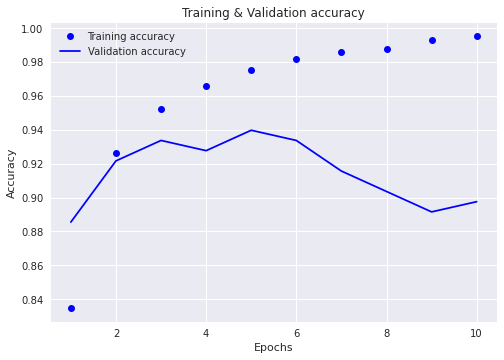

In [105]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

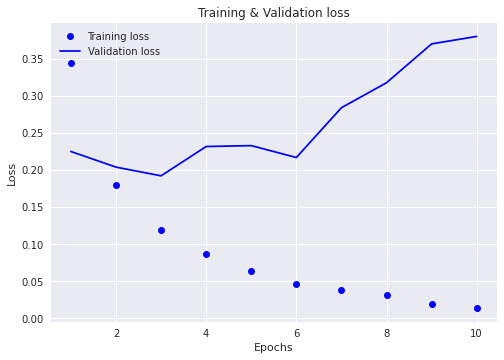

In [106]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [107]:
test_metrics = model.evaluate(X_test, y_test)

253/253 [==============================] - 8s 32ms/step - loss: 0.5405 - accuracy: 0.8975


In [108]:
test_accuracy = test_metrics[1] 
test_loss = test_metrics[0]
print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

Test Accuracy : 0.8974897861480713
Test Accuracy : 0.5404596328735352


In [109]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[3656  360]
 [ 469 3602]]


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4016
           1       0.91      0.88      0.90      4071

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087

Precision: 0.9091367995961636
Recall: 0.8847948906902481
Accuracy: 0.8974897984419439


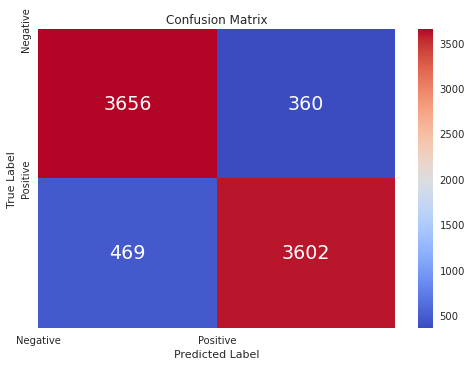

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = model.predict(X_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

# Generate classification report and confusion matrix
class_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and accuracy values from the confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Print classification report and precision/recall/accuracy values
print(class_report)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Plot confusion matrix
#plt.imshow(cm, cmap=plt.cm.Blues)
sns.heatmap(cm,annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.title("Confusion Matrix")
#plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], labels=["Negative", "Positive"])
plt.yticks([0, 1], labels=["Negative", "Positive"])
plt.show()